In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

%pylab inline

from __future__ import division
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn import metrics
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read data
data = pd.read_csv('data3.csv', sep=";" ) 

data.head()

,Unnamed: 0,Name,Family,Born,Sigil,Serves,Known As,Occupation,Relation,Death
0,AGOT,001 Prologue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Gared,NaN,NaN,NaN,"image(""http://awoiaf.westeros.org/images/4/47/...",NaN,Castle Black ranger,NaN,Killed by Eddard Stark at a northern holdfast
2,Ser,Waymar,Royce,"image(""http://awoiaf.westeros.org/images/e/ed/...","image(""http://awoiaf.westeros.org/images/e/ed/...","image(""http://awoiaf.westeros.org/images/4/47/...",NaN,Castle Black ranger,Yohn's Son,Killed by Others north of the Wall
3,NaN,Will,NaN,NaN,NaN,"image(""http://awoiaf.westeros.org/images/4/47/...",NaN,Castle Black ranger,NaN,Killed by a wight (Ser Waymar Royce) north of ...
4,Commander,Jeor,Mormont,"image(""http://awoiaf.westeros.org/images/c/c9/...","image(""http://awoiaf.westeros.org/images/c/c9/...","image(""http://awoiaf.westeros.org/images/4/47/...","Lord Crow, Old Bear","Lord Commander of the Night's Watch, Lord of B...",NaN,Killed by Ollo Lophand at Craster's Keep


In [3]:
# remove NaN from Name field
data["Name"].fillna("other", inplace=True)

In [4]:
# add POV field to each row
import re
pattern = re.compile("[0-9][0-9][0-9]")

POV = []
pov_name = "other"
for row in data['Name']:
    POV.append(pov_name)
    string = str(row)
    #print string
    if (pattern.match(string) == None) == False:
        pov_name = row[4:]    
data['POV'] = POV


In [5]:
# make Occupation lower case to easier manipulation
data['Occupation'] = data['Occupation'].str.lower()

# remove chapter names
pattern = r'[0-9][0-9][0-9]'
data = data[data.Name.str.contains(pattern) == False]

# remove historical characters
pattern = r'Historical'
data = data[data.Death.str.contains(pattern) == False]

# remove character without family name
data = data[pd.isnull(data['Family']) == False]

In [6]:
# check number of NaN's
cols = []
print "# check number of NaN's"
for col in data.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(data[col]).sum()))
    if pd.isnull(data[col]).sum() > 0:
        cols.append(col)
        
# fill NaN with other
print " "
print "# fill NaN with other"
for col in cols:
    data[col].fillna("other", inplace=True)

for col in data.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(data[col]).sum()))

# check number of NaN's
Unnamed: 0, num. NA's: 70
Name, num. NA's: 0
Family, num. NA's: 0
Born, num. NA's: 36
Sigil, num. NA's: 23
Serves, num. NA's: 35
Known As, num. NA's: 174
Occupation, num. NA's: 73
Relation, num. NA's: 147
Death, num. NA's: 0
POV, num. NA's: 0
 
# fill NaN with other
Unnamed: 0, num. NA's: 0
Name, num. NA's: 0
Family, num. NA's: 0
Born, num. NA's: 0
Sigil, num. NA's: 0
Serves, num. NA's: 0
Known As, num. NA's: 0
Occupation, num. NA's: 0
Relation, num. NA's: 0
Death, num. NA's: 0
POV, num. NA's: 0


In [7]:
# describe data
data.describe().T

,count,unique,top,freq
Unnamed: 0,231,11,other,70
Name,231,199,other,15
Family,231,129,Greyjoy,9
Born,231,107,other,36
Sigil,231,110,other,23
Serves,231,24,other,35
Known As,231,58,other,174
Occupation,231,136,other,73
Relation,231,60,other,147
Death,231,160,Killed by Lannisters at the Battle of the Blac...,10


In [8]:
# create target funtion y = killed
pattern = r'Killed'
y = data.Death.str.contains(pattern)
data["killed"] = y

In [9]:
# Percent of killed characted
sum(y)/y.size

0.73593073593073588

In [10]:
# Create features

data["sex"] = -1

pattern = r'Son' #[0-9][0-9]'
data.sex[data.Relation.str.contains(pattern)] = 0
pattern = r'Daughter'
data.sex[data.Relation.str.contains(pattern)] = 1


data["hasNickname"] = 1 * (data["Known As"] != "other")
data["prince"] = data.Occupation.str.contains(r'prince')
data["master-at-arms"] = data.Occupation.str.contains(r'master-at-arms')
data["guard"] = data.Occupation.str.contains(r'guard')
data["ranger"] = data.Occupation.str.contains(r'ranger')
data["hand"] = data.Occupation.str.contains(r'hand')
data["squire"] = data.Occupation.str.contains(r'squire')
data["warden"] = data.Occupation.str.contains(r'warden')


In [11]:
# get new features
jobs = pd.Series(' '.join(data['Occupation']).lower().split()).value_counts()[1:20]
for row in jobs.index:
    data[row] = data.Occupation.str.contains(row) * 1
   

In [12]:
# create features and make dummy variables
data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "Ser")] = 0
data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "Lord")] = 0
data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "King")] = 0
data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "Commander")] = 0
data.sex[(data["guard"] == 1)] = 0
data.sex[(data["ranger"] == 1)] = 0
data.sex[(data["hand"] == 1)] = 0
data.sex[(data["squire"] == 1)] = 0
data.sex[(data["warden"] == 1)] = 0


features_to_use = ['Unnamed: 0','Family', 'Born','Sigil','Serves', 'POV', 'sex']
features_to_use.extend(jobs.index)


data_dummies = data[features_to_use]
data_dummies = pd.get_dummies(data_dummies)


data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "Lady")] = 1
data.sex[(data["sex"] == -1) & (data["Unnamed: 0"] == "Princess")] = 1

data_dummies["hasNickname"] = data["hasNickname"]
data_dummies["prince"] = data["prince"]
data_dummies["master-at-arms"] = data["master-at-arms"]
data_dummies["guard"] = data["guard"]
data_dummies["ranger"] = data["ranger"]
data_dummies["hand"] = data["hand"]
data_dummies["squire"] = data["squire"]
data_dummies["warden"] = data["warden"]

In [13]:
# select major family
df = data.groupby(['Family'])['Family'].count() > 4
major_family = df[df == True].index

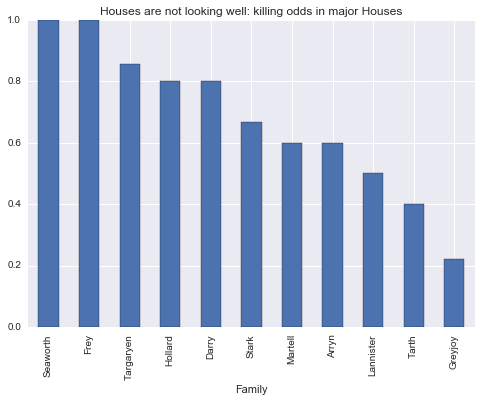

In [14]:
# plot data
df_deaths = data[data.Family.isin(major_family)].groupby(['Family'])['killed'].mean()
df_deaths.index = data[data.Family.isin(major_family)].groupby(['Family'])['Family'].count().index

df_deaths.sort_values(ascending=False)[0:20].plot.bar()
plt.subplot(1,1,1)  # if use subplot
plt.title('Houses are not looking well: killing odds in major Houses')

Family
Greyjoy      9
Lannister    8
Frey         8
Targaryen    7
Stark        6
Tarth        5
Seaworth     5
Martell      5
Hollard      5
Darry        5
Arryn        5
Name: killed, dtype: int64


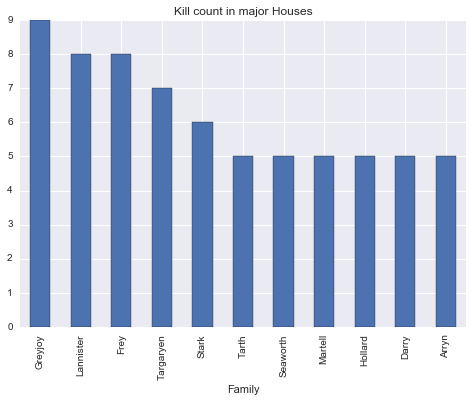

In [15]:
# plot death count
df_deaths = data[data.Family.isin(major_family)].groupby(['Family'])['killed'].count()
df_deaths.index = data[data.Family.isin(major_family)].groupby(['Family'])['Family'].count().index

print df_deaths.sort_values(ascending=False)[0:20]
df_deaths.sort_values(ascending=False)[0:20].plot.bar()
plt.subplot(1,1,1)  # if use subplot
plt.title('Kill count in major Houses')

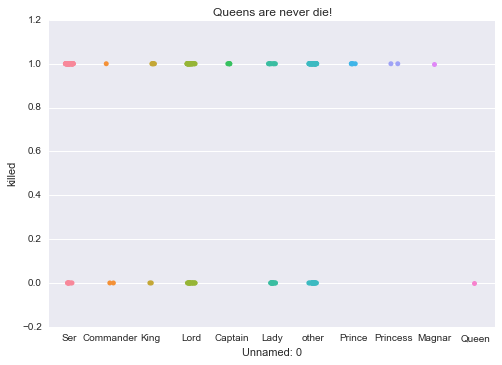

In [16]:
# plot data
sns.stripplot(x="Unnamed: 0", y="killed", data=data, jitter=True)
sns.plt.title('Queens are never die!')

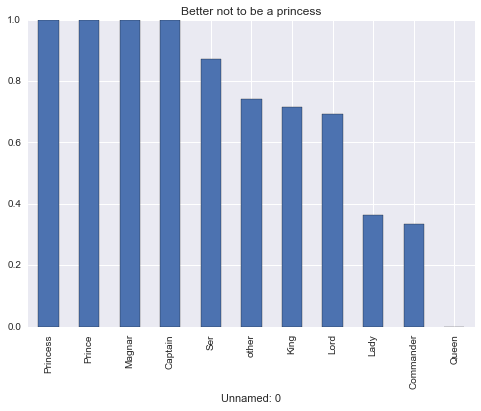

In [17]:
# plot data vs jobs
df_deaths = data.groupby(['Unnamed: 0'])['killed'].mean()
df_deaths.index = data.groupby(['Unnamed: 0'])['Unnamed: 0'].count().index

df_deaths.sort_values(ascending=False)[0:20].plot.bar()
plt.subplot(1,1,1)  # if use subplot
plt.title('Better not to be a princess')

In [18]:
y = y * 1
from sklearn.cross_validation import train_test_split
train_df, test_df, y_df_train, y_df_test = train_test_split(
    data_dummies, y, test_size=0.5, random_state=42)

train_df   = pd.DataFrame(data=train_df)
test_df    = pd.DataFrame(data=test_df)

print 1- sum(y_df_train) / y_df_train.size

0.260869565217


In [19]:
from sklearn import metrics
from sklearn import cross_validation

n_values = np.arange(100, 700, 200)

scores = []
n_outs = []
for n_value in n_values:
    print n_value    
    RF = RandomForestClassifier(n_estimators=n_value, n_jobs=-1, criterion='gini'
                            #
                            , random_state = 42 , max_depth=12
                            , min_samples_split = 2
                           ) 

    score = cross_validation.cross_val_score(RF, train_df, y_df_train,
        cv=4, scoring='accuracy')
    
    scores.append(score.mean())
    n_outs.append(n_value)
print scores
print n_outs

100
300
500
[0.79115353037766822, 0.80008210180623962, 0.80901067323481124]
[100, 300, 500]


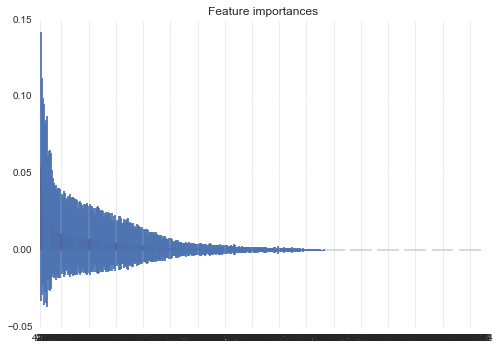

In [26]:
RF = RandomForestClassifier(n_estimators=1500, n_jobs=-1, criterion='gini'
                        , random_state = 42 
                        , max_depth=12
                        , min_samples_split = 2
                       )

# Code from documentation
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

RF.fit(train_df,y_df_train)
X = train_df


importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# train results
y_pred =  RF.predict(train_df)
y_true = y_df_train.values
print accuracy_score(y_true, y_pred)

confusion_matrix(y_true, y_pred)

0.939130434783


array([[23,  7],
       [ 0, 85]])

In [22]:
# test results
y_pred =  RF.predict(test_df)
y_true = y_df_test.values
print accuracy_score(y_true, y_pred)
print "Naive accuracy: " + str(sum(y_true) / y_true.size)

0.758620689655
Naive accuracy: 0.73275862069


In [23]:
confusion_matrix(y_true, y_pred)

array([[ 3, 28],
       [ 0, 85]])

In [24]:
from sklearn.metrics import roc_auc_score

y_scores = RF.predict_proba(test_df)[:,1]
roc_auc_score(y_true, y_scores)

0.70132827324478186

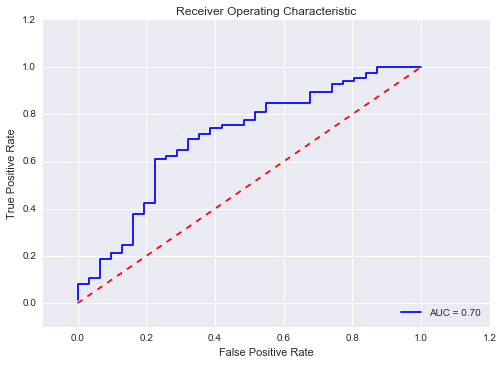

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
actual = y_true
predictions = RF.predict_proba(test_df)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()